## Generating SLIC images for regions 3 and 4

In [1]:
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
region = 'x04'

In [3]:
image = np.load(f'xingu_dataset/scenes_allbands/allbands_{region}.npy')[:, :, [5, 4, 0]]

In [4]:
# segment image using SLIC
segments = slic(image, n_segments=4000, max_num_iter=10)

In [5]:
np.unique(segments).shape

(2448,)

In [6]:
"""
I implemented the function get_major_class(segment) because it ensures
that the truth mask is not invalid (exception is raised if it is). Also,
it allows us to change the pixel values for each class if needed.
"""
def get_major_class(segment):
    if np.argmax(np.bincount(segment.flatten())) == 0:
        return "forest"
    elif np.argmax(np.bincount(segment.flatten())) == 1:
        return "non forest"
    else:
        raise Exception("Invalid truth mask!")

def get_pixel_value(segment):
    if get_major_class(segment) == "forest":
        return 0
    else:
        return 1

In [7]:
# load truth mask
truth_mask = np.load(f'xingu_dataset/truth_masks/truth_{region}.npy')
truth_mask = np.squeeze(truth_mask)

In [8]:
# iterate through each segment and assign the pixel value of the majority class
slic_preds = np.zeros(image.shape[:2], dtype="float64")
for (i, segVal) in enumerate(np.unique(segments)):
    slic_preds[segments == segVal] = get_pixel_value(truth_mask[segments == segVal])

Text(0.5, 1.0, 'SLIC predictions')

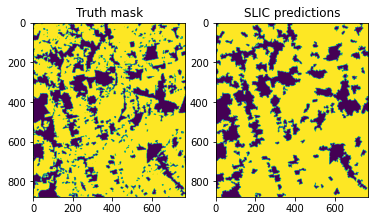

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(truth_mask)
ax[0].set_title("Truth mask")
ax[1].imshow(slic_preds)
ax[1].set_title("SLIC predictions")

### Time to flag the tp, tn, fp, fn on the SLIC predictions

In [10]:
# Define color mappings
true_positive_color = [255, 255, 255]  # White
true_negative_color = [0, 0, 0]        # Black
false_positive_color = [0, 0, 255]     # Blue
false_negative_color = [255, 0, 0]     # Red

In [11]:
# compare unique values
print(f'unique values in slic_preds: {np.unique(slic_preds)} | shape: {slic_preds.shape}')
print(f'unique values in truth_mask: {np.unique(truth_mask)} | shape: {truth_mask.shape}')

unique values in slic_preds: [0. 1.] | shape: (879, 768)
unique values in truth_mask: [0 1] | shape: (879, 768)


(879, 768)
(879, 768)
(879, 768)
(879, 768)


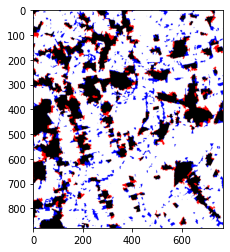

In [12]:
# Initialize an empty result image
result_image = np.zeros(truth_mask.shape + (3,))

# Identify true positives, true negatives, false positives, and false negatives
true_positives = np.logical_and(truth_mask == 1, slic_preds == 1)
true_negatives = np.logical_and(truth_mask == 0, slic_preds == 0)
false_positives = np.logical_and(truth_mask == 0, slic_preds == 1)
false_negatives = np.logical_and(truth_mask == 1, slic_preds == 0)

# print their shapes
print(true_positives.shape)
print(true_negatives.shape)
print(false_positives.shape)
print(false_negatives.shape)

# Assign colors to each category in the result image
result_image[true_positives] = true_positive_color
result_image[true_negatives] = true_negative_color
result_image[false_positives] = false_positive_color
result_image[false_negatives] = false_negative_color

# Create a PIL image from the result
result_image = Image.fromarray(result_image.astype(np.uint8))
plt.imshow(result_image)

In [13]:
# save image
result_image.save(f'results/confusionMaskSLIC_{region}.png')